<a href="https://colab.research.google.com/github/Ashan-KS/ML_CW/blob/main/2330974_20221031_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Corpus Preparation**

## **1.1 Imports**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTENC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

## **1.2 Fine tuning to Dataset's logic**

In [107]:
# Loading the dataset
df = pd.read_csv('/content/bank-additional-full.csv', delimiter=';')

In [108]:
# Identifying duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Removing duplicates
df = df.drop_duplicates()
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 12
Number of duplicate rows: 0


In [109]:
# Replacing the 999 in pdays with -1
df['pdays'] = df['pdays'].replace(999, -1)

# Dropping the duration feature as recommended
df = df.drop('duration', axis=1)
# df = df.drop('pdays', axis=1)

<ipython-input-109-7fca91929d60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pdays'] = df['pdays'].replace(999, -1)


In [110]:
# Fix: Set `previous` to 0 where `pdays == -1` and `previous != 0`
df.loc[(df['pdays'] == -1) & (df['previous'] != 0), 'previous'] = 0

## **1.3 Features Overview**

In [111]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [112]:
# Shape and head of the dataset
print("Dataset shape: ",df.shape,"\n")
df.head()

Dataset shape:  (41176, 20) 



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [113]:
# Dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  campaign        41176 non-null  int64  
 11  pdays           41176 non-null  int64  
 12  previous        41176 non-null  int64  
 13  poutcome        41176 non-null  object 
 14  emp.var.rate    41176 non-null  float64
 15  cons.price.idx  41176 non-null  float64
 16  cons.conf.idx   41176 non-null  float64
 17  euribor3m       41176 non-null  floa

In [114]:
# Statistics of all numerical columns
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,2.567879,-0.741913,0.061104,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,2.770318,1.510540,0.360337,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,1.000000,-1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,-1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,-1.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,-1.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [115]:
# Print unique values for each categorical column
for column in categorical_cols:
    print('Column:', column)
    print(df[column].unique())
    print()

Column: job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Column: marital
['married' 'single' 'divorced' 'unknown']

Column: education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Column: default
['no' 'unknown' 'yes']

Column: housing
['no' 'yes' 'unknown']

Column: loan
['no' 'yes' 'unknown']

Column: contact
['telephone' 'cellular']

Column: month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Column: day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']

Column: poutcome
['nonexistent' 'failure' 'success']

Column: y
['no' 'yes']



## **1.4 Preprocessing**

### **1.4.1 Handling null values**

In [116]:
# Checking for null values
print(df.isnull().sum())

print("\nThere are no null values in this dataset")

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no null values in this dataset


### **1.4.2 Splitting the dataset**

In [117]:
# Extract features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y'].map({'yes': 1, 'no': 0})

In [118]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
# Select numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Select categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

### **1.4.3 Handling the class imbalance of the training set**

In [120]:
# Get categorical column indices
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# Apply SMOTENC to handle imbalanced classes
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

# Check the new distribution
balanced_distribution = pd.Series(y_train).value_counts()
print("\nClass Distribution After Applying SMOTE:")
print(balanced_distribution)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Class Distribution After Applying SMOTE:
y
0    29272
1    29272
Name: count, dtype: int64


### **1.4.4 Scaling the training & testing sets**

In [121]:
# Initialize the scaler
scaler = StandardScaler()

if len(categorical_cols) > 0:
    # Separate categorical and numerical features
    X_train_categorical = X_train[categorical_cols]
    X_train_numerical = X_train.drop(columns=categorical_cols)

    X_test_categorical = X_test[categorical_cols]
    X_test_numerical = X_test.drop(columns=categorical_cols)

    # Scale only numerical features
    X_train_numerical = scaler.fit_transform(X_train_numerical)
    X_test_numerical = scaler.transform(X_test_numerical)

    # Convert scaled numerical features back to DataFrames with original column names
    X_train_numerical = pd.DataFrame(X_train_numerical, columns=X_train.drop(columns=categorical_cols).columns, index=X_train.index)
    X_test_numerical = pd.DataFrame(X_test_numerical, columns=X_test.drop(columns=categorical_cols).columns, index=X_test.index)

    # Combine the scaled numerical features with the categorical features (no scaling on categorical)
    X_train = pd.concat([X_train_numerical, X_train_categorical], axis=1)
    X_test = pd.concat([X_test_numerical, X_test_categorical], axis=1)
else:
    # If no categorical columns, just apply scaling to the entire dataset
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


### **1.4.5 Encoding the training & testing sets**

In [122]:
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the training data and transform it
    X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    # Transform the testing data using the same encoder
    X_test_encoded = encoder.transform(X_test[categorical_cols])
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    # Combine encoded categorical features with numerical ones for both X_train and X_test
    X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded], axis=1)
    X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded], axis=1)
else:
    # If no categorical columns, just reset the index for both
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

### **1.4.6 Handling the outliers of the training set**

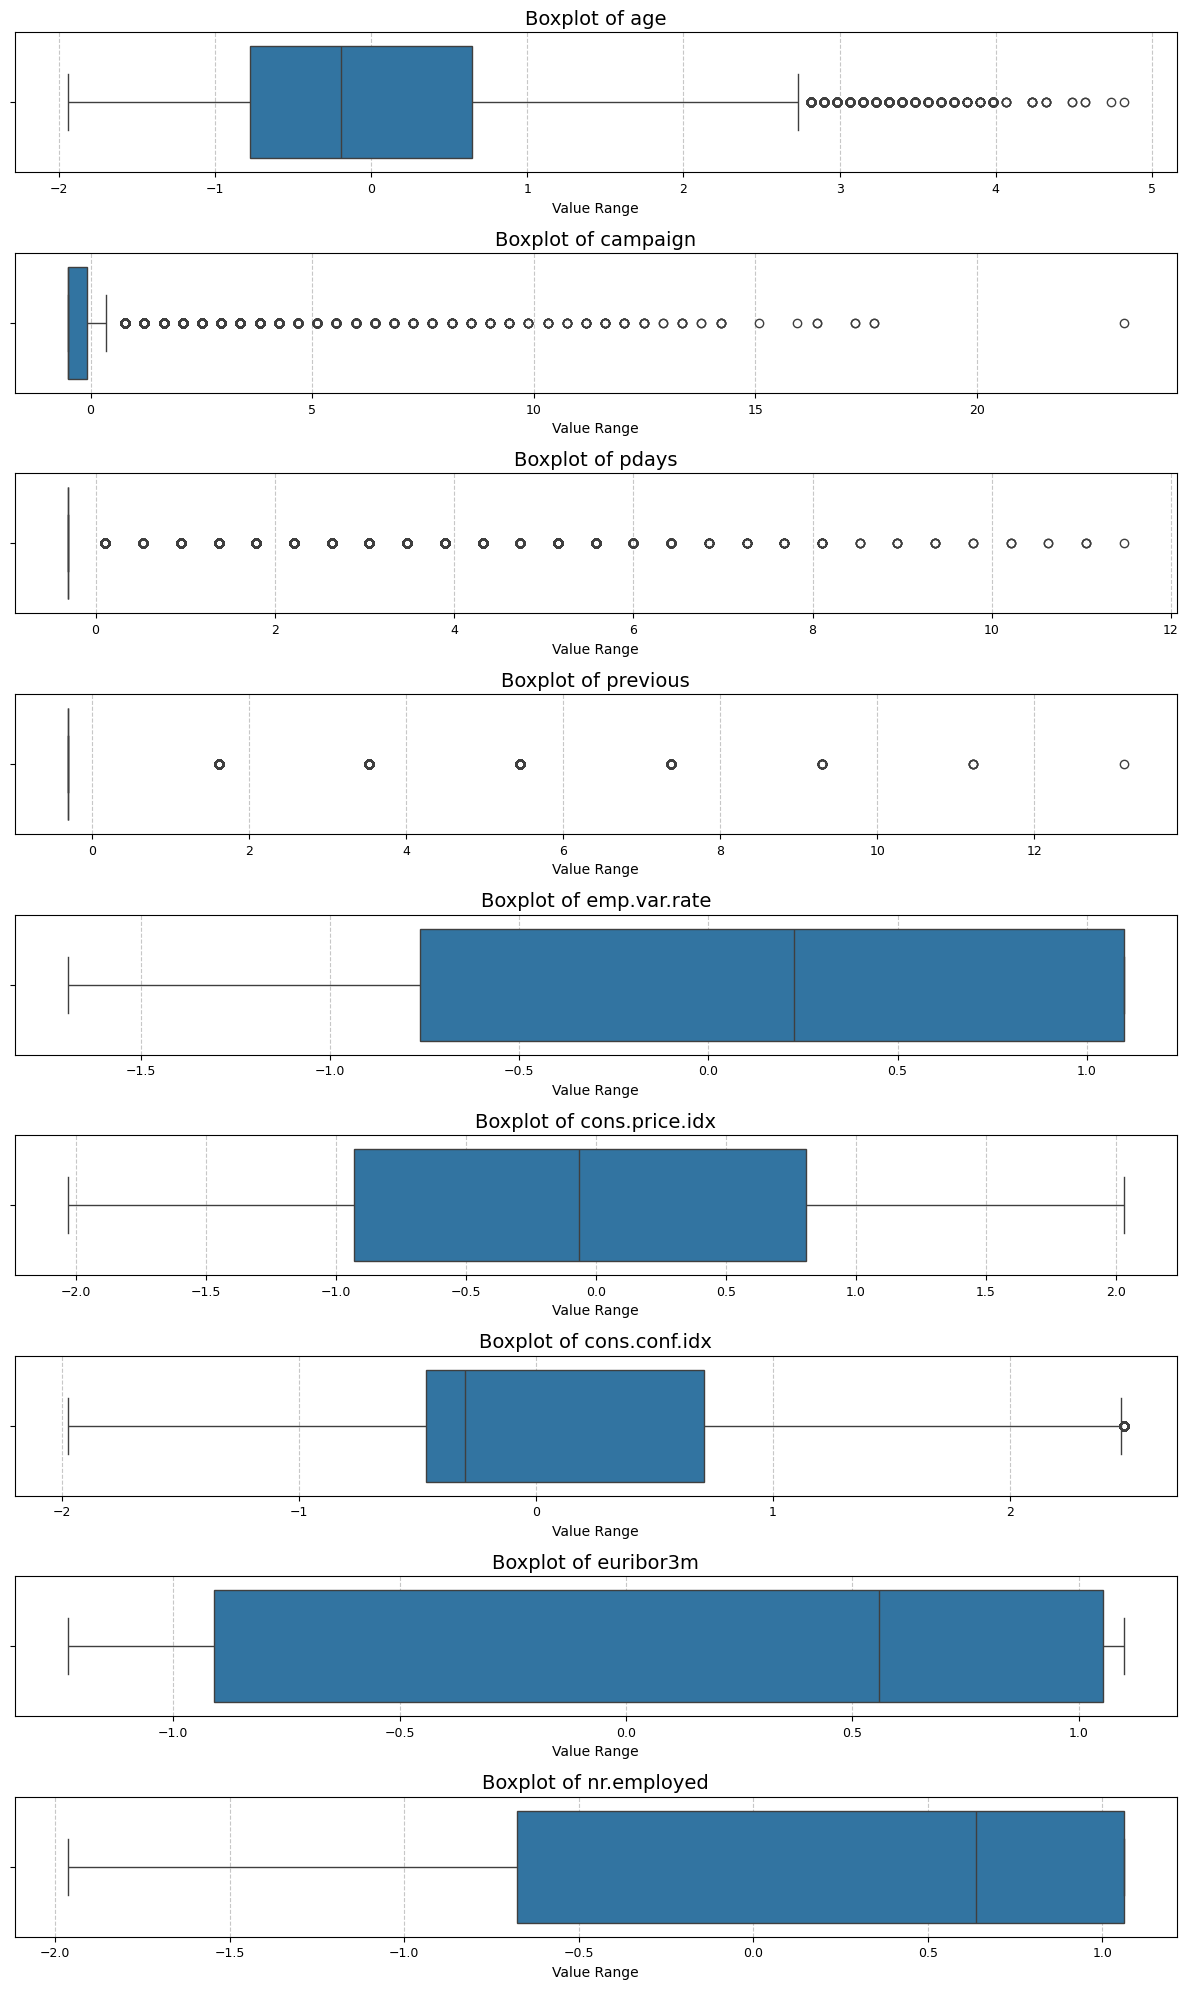


age: 1076 outliers (1.84%)

campaign: 7975 outliers (13.62%)

pdays: 6673 outliers (11.40%)

previous: 6373 outliers (10.89%)

emp.var.rate: 0 outliers (0.00%)

cons.price.idx: 0 outliers (0.00%)

cons.conf.idx: 1326 outliers (2.26%)

euribor3m: 0 outliers (0.00%)

nr.employed: 0 outliers (0.00%)


In [123]:
# Create subplots for each numerical feature
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(12, 20), sharex=False)

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=X_train, x=col, ax=axes[i], orient="h")
    axes[i].set_title(f"Boxplot of {col}", fontsize=14)
    axes[i].set_xlabel("Value Range", fontsize=10)
    axes[i].grid(axis="x", linestyle="--", alpha=0.7)
    axes[i].tick_params(axis="x", labelsize=9)
    axes[i].tick_params(axis="y", labelsize=9)

plt.tight_layout()
plt.show()

# Calculate outliers using IQR method
def get_outliers_count(X_train, column):
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)][column]
    return len(outliers)

# Print outlier counts
for col in numerical_cols:
    outlier_count = get_outliers_count(X_train, col)
    outlier_percentage = (outlier_count / len(X_train)) * 100
    print(f"\n{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")

In [124]:
# Cap outliers using the IQR method
def cap_outliers(df, column):
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[column] =X_train[column].clip(lower=lower_bound, upper=upper_bound)

# Apply capping to numerical features
for col in numerical_cols:
    cap_outliers(X_train, col)

# **2. Implementation**

In [125]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Print the number of components
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 28


## **2.1 Neural Network Implementation**

In [126]:
# Build the Neural Network Model
nn_model = Sequential([
    # Input layer and first hidden layer
    Dense(512, input_dim=X_train.shape[1], activation='relu'),  # Increase neurons for better feature extraction
    BatchNormalization(),
    Dropout(0.4),  # Slightly higher dropout to reduce overfitting

    # Second hidden layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third hidden layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Fourth hidden layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Fifth hidden layer
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')  # For binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [127]:
# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [128]:
# Summary of the model
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,409 (755.50 KB)

 Trainable params: 191,425 (747.75 KB)

 Non-trainable params: 1,984 (7.75 KB)

In [129]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', # or 'val_accuracy'
                               patience=10,          # Number of epochs to wait for improvement
                               restore_best_weights=True, # Restore the model to the best weights
                               verbose=1)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert list to numpy array
    y=y_train  # Replace with your training labels
)
class_weights = dict(enumerate(class_weights))

# Train the model
history = nn_model.fit(X_train, y_train, class_weight=class_weights, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7414 - loss: 0.5550 - val_accuracy: 0.6527 - val_loss: 0.5485
Epoch 2/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7840 - loss: 0.4776 - val_accuracy: 0.6613 - val_loss: 0.5369
Epoch 3/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7938 - loss: 0.4569 - val_accuracy: 0.6879 - val_loss: 0.5300
Epoch 4/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7974 - loss: 0.4440 - val_accuracy: 0.6939 - val_loss: 0.5244
Epoch 5/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8041 - loss: 0.4330 - val_accuracy: 0.7234 - val_loss: 0.5050
Epoch 6/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8059 - loss: 0.4324 - val_accuracy: 0.7814 - val_loss: 0.4612
Epoch 7/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8045 - loss: 0.4321 - val_accuracy: 0.7077 - val_loss: 0.5154
Epoch 8/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8115 

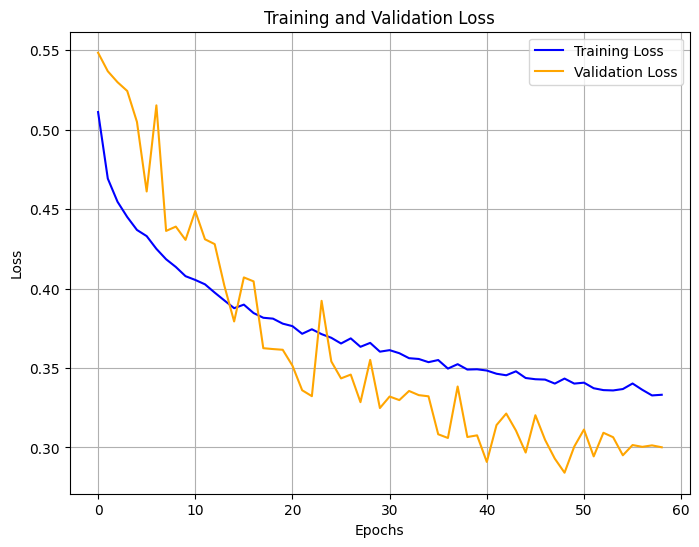

In [133]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

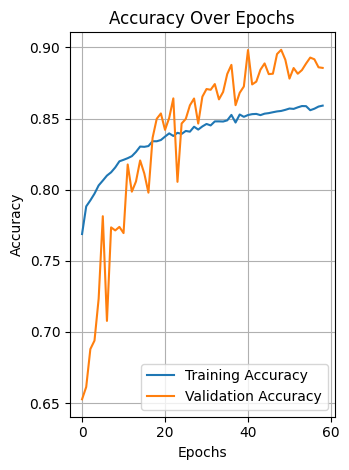

In [134]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [135]:
# Make predictions
nn_predictions = nn_model.predict(X_test)
nn_predictions = (nn_predictions > 0.5).astype(int)  # Convert probabilities to binary

# Evaluate the model
print("\nNeural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, nn_predictions):.2f}")
print("Classification Report:")
print(classification_report(y_test, nn_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, nn_predictions))

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Neural Network Performance:
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      7265
           1       0.33      0.42      0.37       971

    accuracy                           0.83      8236
   macro avg       0.63      0.65      0.64      8236
weighted avg       0.85      0.83      0.84      8236

Confusion Matrix:
[[6441  824]
 [ 560  411]]


In [105]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)  # cv=5 means 5-fold cross-validation

# Print the cross-validation results
print("Cross-Validation Scores:", cv_scores)
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores):.2f}")

Cross-Validation Scores: [0.79887266 0.93603211 0.94380391 0.94021693 0.93628288]
Mean CV Score: 0.91
Standard Deviation of CV Scores: 0.06


In [106]:
# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print("Classification Report:")
print(classification_report(y_test, rf_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

Random Forest Classifier Performance:
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7265
           1       0.41      0.40      0.41       971

    accuracy                           0.86      8236
   macro avg       0.66      0.66      0.66      8236
weighted avg       0.86      0.86      0.86      8236

Confusion Matrix:
[[6698  567]
 [ 578  393]]
